# Imports + Installs

In [1]:
!pip install "gym[atari, accept-rom-license]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 21.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=b3a7f2381abe7b1e220f0424248e7becae6c8378fbaf8caeebf50a6a64adf392
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [8]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import cv2
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
from google.colab import files
warnings.filterwarnings("ignore")

# Classes + Helpers

## Environment

In [15]:
class RepeatActionAndMaxFrame(gym.Wrapper):
  def __init__(self, env=None, repeat=4, clip_rewards=False, no_ops=0, fire_first=False):
    super(RepeatActionAndMaxFrame, self).__init__(env)
    self.repeat = repeat
    self.shape = env.observation_space.low.shape
    self.frame_buffer = np.zeros_like((2, self.shape))
    self.clip_rewards = clip_rewards 
    self.no_ops = no_ops
    self.fire_first = fire_first
  
  def step(self, action):
    total_reward = 0.0
    done = False
    for i in range(self.repeat):
      obs, reward, done, info = self.env.step(action)
      if self.clip_rewards:
        reward = np.clip(np.array([reward]), -1, 1)[0]
      total_reward += reward
      idx = i % 2
      self.frame_buffer[idx] = obs
      if done:
        break

    max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
    return max_frame, total_reward, done, info
  
  def reset(self):
    obs = self.env.reset()
    no_ops = np.random.randint(self.no_ops) + 1 if self.no_ops > 0 else 0
    for _ in range(no_ops):
      _, _, done, _ = self.env.step(0)
      if done:
        self.env.reset()
    if self.fire_first:
      assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
      obs, _, _, _ = self.env.step(1)

    self.frame_buffer = np.zeros_like((2, self.shape))
    self.frame_buffer[0] = obs
    return obs


class PreprocessFrame(gym.ObservationWrapper):
  def __init__(self, shape, env=None):
    super(PreprocessFrame, self).__init__(env)
    self.shape = (shape[2], shape[0], shape[1])
    self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                            shape=self.shape,
                                            dtype=np.float32)
  
  def observation(self, obs):
    new_frame = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
    resized_screen = cv2.resize(new_frame, 
                                self.shape[1:],
                                interpolation=cv2.INTER_AREA)
    new_obs = np.array(resized_screen, dtype=np.float16).reshape(self.shape)
    new_obs /= 255.0

    return new_obs


class StackFrames(gym.ObservationWrapper):
  def __init__(self, env, repeat):
    super(StackFrames, self).__init__(env)
    self.observation_space = gym.spaces.Box(
        env.observation_space.low.repeat(repeat, axis=0),
        env.observation_space.high.repeat(repeat, axis=0)
    )
    self.stack = collections.deque(maxlen=repeat)

  def reset(self):
    self.stack.clear()
    observation = self.env.reset()
    for _ in range(self.stack.maxlen):
      self.stack.append(observation)
    
    return np.array(self.stack).reshape(self.observation_space.low.shape)
  
  def observation(self, observation):
    self.stack.append(observation)
    return np.array(self.stack).reshape(self.observation_space.low.shape)


def make_env(env_name, shape=(84, 84, 1), repeat=4, clip_rewards=False, no_ops=0, fire_first=False):
  env = gym.make(env_name)
  env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
  env = PreprocessFrame(shape, env)
  env = StackFrames(env, repeat)
  return env

## Agent

In [16]:
class ReplayBuffer():
  def __init__(self, max_size, input_shape, n_actions):
    self.mem_size = max_size
    self.mem_counter = 0
    self.state_memory = np.zeros(
        (self.mem_size, *input_shape),
        dtype=np.float32
    )
    self.new_state_memory = np.zeros(
        (self.mem_size, *input_shape),
        dtype=np.float32
    )
    self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
  
  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_counter % self.mem_size
    self.state_memory[index] = state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.new_state_memory[index] = state_
    self.terminal_memory[index] = done
    self.mem_counter += 1
  
  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_counter, self.mem_size)
    batch = np.random.choice(max_mem, batch_size, replace=True)
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    states_ = self.new_state_memory[batch]
    dones = self.terminal_memory[batch]

    return states, actions, rewards, states_, dones


class DuelingDeepQNetwork(nn.Module):
  def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
    super(DuelingDeepQNetwork, self).__init__()
    self.checkpoint_dir = chkpt_dir
    self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
    if not os.path.exists(self.checkpoint_dir):
      os.makedirs(self.checkpoint_dir)

    self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

    fc_input_dims = self.calculate_conv_output_dims(input_dims)
    
    self.fc1 = nn.Linear(fc_input_dims, 512)
    self.V = nn.Linear(512, 1)
    self.A = nn.Linear(512, n_actions)

    self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def calculate_conv_output_dims(self, input_dims):
    state = T.zeros(1, *input_dims)
    dims = self.conv1(state)
    dims = self.conv2(dims)
    dims = self.conv3(dims)
    return int(np.prod(dims.size()))

  def forward(self, state):
    state = F.relu(self.conv1(state))
    state = F.relu(self.conv2(state))
    state = F.relu(self.conv3(state))
    # conv3 shape is: batch_size x n_filters x H x W
    state = state.view(state.size()[0], -1)
    state = F.relu(self.fc1(state))
    V = self.V(state)
    A = self.A(state)

    return V, A

  def save_checkpoint(self):
    print('... saving checkpoint ...')
    T.save(self.state_dict(), self.checkpoint_file)
  
  def load_checkpoint(self):
    print('... loading checkpoint ...')
    self.load_state_dict(T.load(self.checkpoint_file))


class DuelingDQNAgent():
  def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
               mem_size, batch_size, eps_min=0.01, eps_dec=5e-7, 
               replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
    self.gamma = gamma
    self.epsilon = epsilon
    self.lr = lr
    self.n_actions = n_actions
    self.input_dims = input_dims
    self.batch_size = batch_size
    self.eps_min = eps_min
    self.eps_dec = eps_dec
    self.replace_target_counter = replace
    self.algo = algo
    self.env_name = env_name
    self.chkpt_dir = chkpt_dir
    self.action_space = [i for i in range(self.n_actions)]
    self.learn_step_counter = 0

    self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

    self.Q_eval = DuelingDeepQNetwork(self.lr, self.n_actions,
                                      input_dims=self.input_dims,
                                      name=self.env_name + '_' + self.algo + '_Q_eval.pth',
                                      chkpt_dir=self.chkpt_dir)

    self.Q_next = DuelingDeepQNetwork(self.lr, self.n_actions,
                                      input_dims=self.input_dims,
                                      name=self.env_name + '_' + self.algo + '_Q_next.pth',
                                      chkpt_dir=self.chkpt_dir)   
  
  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      state = T.tensor([observation], dtype=T.float).to(self.Q_eval.device)
      _, advantage = self.Q_eval.forward(state)
      action = T.argmax(advantage).item()
    else:
      action = np.random.choice(self.action_space)
    return action
  
  def store_transition(self, state, action, reward, state_, done):
    self.memory.store_transition(state, action, reward, state_, done)
  
  def sample_memory(self):
    state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
    states = T.tensor(state).to(self.Q_eval.device)
    actions = T.tensor(action).to(self.Q_eval.device)
    rewards = T.tensor(reward).to(self.Q_eval.device)
    states_ = T.tensor(new_state).to(self.Q_eval.device)
    dones = T.tensor(done).to(self.Q_eval.device)

    return states, actions, rewards, states_, dones
  
  def replace_target_network(self):
    if self.learn_step_counter % self.replace_target_counter == 0:
      self.Q_next.load_state_dict(self.Q_eval.state_dict())
  
  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
  
  def save_models(self):
    self.Q_eval.save_checkpoint()
    self.Q_next.save_checkpoint()

  def load_models(self):
    self.Q_eval.load_checkpoint()
    self.Q_next.load_checkpoint()
  
  def learn(self):
    if self.memory.mem_counter < self.batch_size:
      return 
    
    self.Q_eval.optimizer.zero_grad()

    self.replace_target_network()
    states, actions, rewards, states_, dones = self.sample_memory()

    indices = np.arange(self.batch_size)

    # ================== CHANGES START HERE ... =====================
    Vs, As = self.Q_eval.forward(states)
    Vs_, As_  = self.Q_next.forward(states_)

    Q_pred = T.add(Vs, (As - As.mean(dim=1, keepdim=True)))[indices, actions]
    Q_next = T.add(Vs_, (As_ - As_.mean(dim=1, keepdim=True))).max(dim=1)[0]
    
    # where the episodes are reach a terminal state (done=1),
    # there target must be equal to r
    Q_next[dones] = 0.0
    Q_target = rewards + self.gamma * Q_next
    # ================== CHANGES END HERE ... =======================

    loss = self.Q_eval.loss(Q_target, Q_pred).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()
    self.learn_step_counter += 1

    self.decrement_epsilon()

## Other

In [17]:
def  plot_learning_curve(x, scores, epsilons, lines=None):
  fig = plt.figure(figsize=(30, 10))
  ax = fig.add_subplot(111, label='1')
  ax2 = fig.add_subplot(111, label='2', frame_on=False)

  ax.plot(x, epsilons, color='C0')
  ax.set_xlabel("Training steps", color="C0")
  ax.set_ylabel("Epsilon", color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors='C0')

  N = len(scores)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])
  
  ax2.scatter(x, running_avg, color="C1")
  ax2.axes.get_xaxis().set_visible(False)
  ax2.yaxis.tick_right()
  ax2.set_ylabel('Score', color="C1")
  ax2.yaxis.set_label_position('right')
  ax2.tick_params(axis='y', colors="C1")

  if lines is not None:
    for line in lines:
      plt.axvline(x=line)
  
  # plt.savefig(filename)

# MAIN


Game 1
Episode: 0, score: -19.0, avg_score: -19.0, best_score: -inf, epsilon: 0.9901900000000446
... saving checkpoint ...
... saving checkpoint ...

Game 2
Episode: 1, score: -19.0, avg_score: -19.0, best_score: -19.0, epsilon: 0.98023000000009

Game 3
Episode: 2, score: -21.0, avg_score: -19.666666666666668, best_score: -19.0, epsilon: 0.9717000000001288

Game 4
Episode: 3, score: -20.0, avg_score: -19.75, best_score: -19.0, epsilon: 0.9607500000001786

Game 5
Episode: 4, score: -21.0, avg_score: -20.0, best_score: -19.0, epsilon: 0.9519300000002188

Game 6
Episode: 5, score: -20.0, avg_score: -20.0, best_score: -19.0, epsilon: 0.9420100000002639

Game 7
Episode: 6, score: -21.0, avg_score: -20.142857142857142, best_score: -19.0, epsilon: 0.9330000000003049

Game 8
Episode: 7, score: -20.0, avg_score: -20.125, best_score: -19.0, epsilon: 0.922880000000351

Game 9
Episode: 8, score: -19.0, avg_score: -20.0, best_score: -19.0, epsilon: 0.9114000000004032

Game 10
Episode: 9, score: -2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

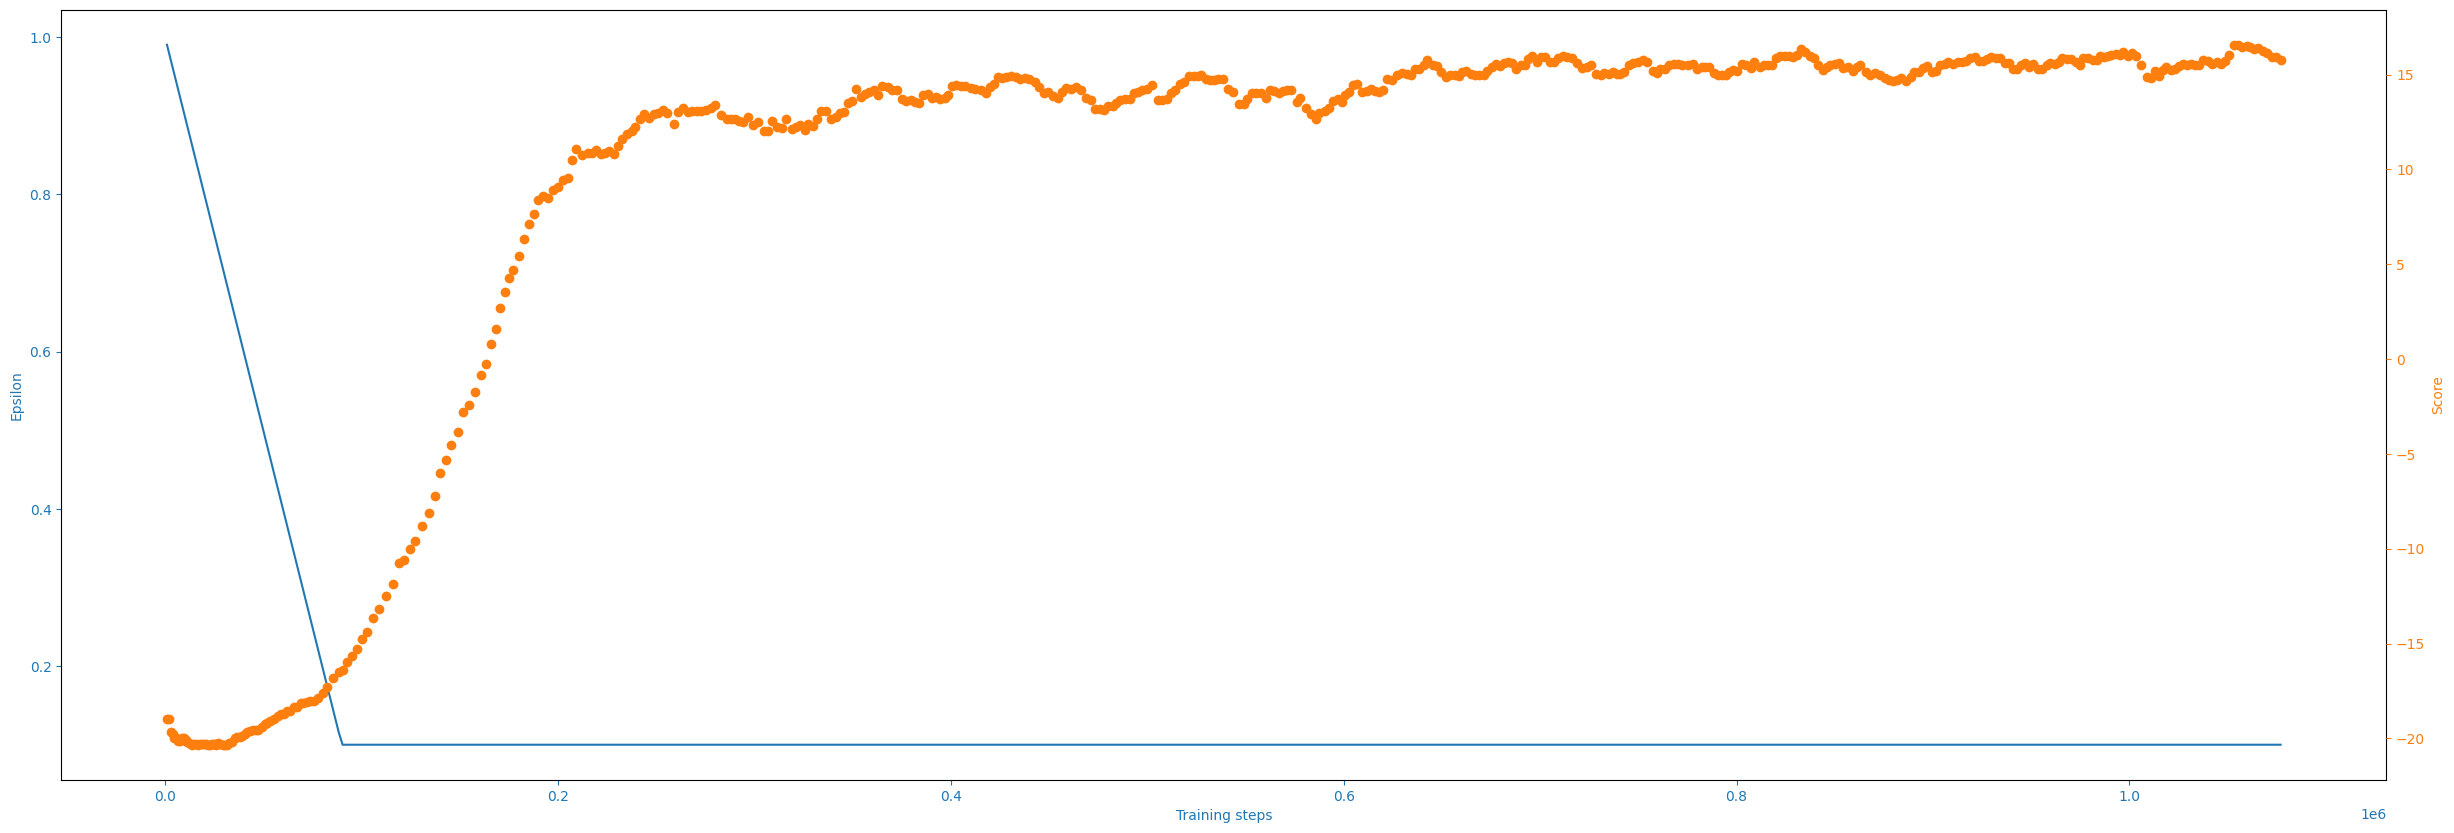

In [18]:
!rm -rf './models'
env = make_env('PongNoFrameskip-v4')

best_score = -np.inf
load_checkpoint = False
n_games = 500

agent = DuelingDQNAgent(gamma=0.99, epsilon=1.0, lr=1e-4,
                        input_dims=(env.observation_space.shape),
                        n_actions=env.action_space.n, mem_size=20000, 
                        eps_min=0.1, batch_size=32, replace=1000, 
                        eps_dec=1e-5, chkpt_dir='models/', 
                        algo='DuelingDQNAgent', env_name='PongNoFrameskip-v4')

if load_checkpoint:
  agent.load_models()

# file_name = agent.algo +'_' + agent.env_name + '_lr' + str(agent.lr) + '_' + str(n_games) + '_games'
# figure_file = 'plots/' + file_name + '.png'

n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
  print(f"\nGame {i+1}")
  done = False
  score = 0
  observation = env.reset()

  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward

    if not load_checkpoint:
      agent.store_transition(observation, action, reward, observation_, int(done))
      agent.learn()
    
    observation = observation_
    n_steps += 1

  scores.append(score)
  steps_array.append(n_steps)

  avg_score = np.mean(scores[-100:])
  print(f"Episode: {i}, score: {score}, avg_score: {avg_score}, best_score: {best_score}, epsilon: {agent.epsilon}")

  if avg_score > best_score:
    if not load_checkpoint:
      agent.save_models()
    best_score = avg_score
  
  eps_history.append(agent.epsilon)

plot_learning_curve(steps_array, scores, eps_history)

df = pd.DataFrame(
    {
        'steps_array': steps_array, 
        'scores': scores, 
        'eps_history': eps_history
    }
)

filename = 'Atari_DuelingDQL_results.csv' 
df.to_csv(filename)
files.download(filename) 